In [47]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from datasets import load_dataset
import json
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt


In [58]:
class MLP(nn.Module):

    def __init__(self, d, n_hidden):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear( d**2-1, n_hidden),
            # nn.Tanh(),
            nn.ReLU(),
            # nn.Sigmoid(),
            # nn.Dropout(dropout),
            # nn.Linear(n_hidden, 64),
            # nn.ReLU(),
            # # nn.Tanh(),
            # nn.Linear(64, 2),
            nn.Linear(n_hidden, 2),
            nn.Dropout(dropout),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.1)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.1)


    def forward(self, x, targets=None):

        y = F.sigmoid(self.net(x))
        if targets is None:
            loss = None
        else:
            eps = 1e-9
            loss = -torch.sum((targets*torch.log(y+eps)+(1-targets)*torch.log(1-y+eps)).mean(dim=0))
        return y, loss


In [45]:
d = 7 # must be an odd number
n_hidden = 512
dropout = 0.2
model = MLP(d, n_hidden)
device = "cuda" if torch.cuda.is_available() else "cpu"
m = model.to(device)

# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters()), 'parameters')

BATCH_SIZE = 1000
p_err_train = 0.1
p_err_val = 0.15
dataset = load_dataset("json", data_files={
        'train' : f"datasets/train_d_{d}_p_{p_err_train:.2f}.json",
        'val' : f"datasets/val_d_{d}_p_{p_err_val:.2f}.json"
    })

def collate_fn(examples):
    input = [example['input'] for example in examples]
    target = [example['target'] for example in examples]
    return {'input': input, 'target': target}

data_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, collate_fn=collate_fn)
data_loader_val = DataLoader(dataset["val"], batch_size=BATCH_SIZE, collate_fn=collate_fn)
print(dataset["train"])

58050 parameters


Generating train split: 1000000 examples [00:02, 463778.42 examples/s]
Generating val split: 1000 examples [00:00, 132996.29 examples/s]

Dataset({
    features: ['errors', 'input', 'target'],
    num_rows: 1000000
})


In [16]:
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    # for split in ['train', 'val']:
    # num_evals = 100
    # losses = torch.zeros(num_evals)#eval_iters)
    losses = torch.zeros(eval_iters)
    i = 0
    data_loader_loss = DataLoader(dataset["train"], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
    for batch in data_loader_loss:
    # for batch in data_loader:
        if i >= eval_iters:
            break
        X = torch.tensor(batch['input']).to(device)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,Y)

        losses[i] = loss.item()
        i += 1
    out["train"] = losses.mean()

    i = 0
    out["val"] = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X,Y)

        out["val"] += loss.item()
        i += 1
    out["val"] /= i
    
    model.train()
    return out

def estimate_accuracy():
    model.eval()
    i = 0
    acc = 0
    for batch in data_loader_val:
        X = torch.tensor(batch['input']).to(device)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, _ = model(X)
        pred = (err_probs > 0.5).to(Y)
        # print(err_probs.shape, Y.shape)
        acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
        i += 1
    acc /= i
    
    model.train()
    return acc.item()


In [17]:
learning_rate = 2e-3
# # create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

eval_interval = 100
eval_iters =  100
num_epochs = 1000

loss_train = []
loss_val = []
acc_val = []
for epoch in range(num_epochs):
    iter = 0
    data_loader = DataLoader(dataset["train"], batch_size=BATCH_SIZE, collate_fn=collate_fn, shuffle=True)
    for i_b, batch in enumerate(data_loader):
        # if i_b>= eval_iters:
        #     break

        # every once in a while evaluate the loss on train and val sets
        # if epoch% 10 ==0 and iter % eval_interval == 0:
        if iter % eval_interval == 0:
            losses = estimate_loss()
            acc = estimate_accuracy()
            print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}, val acc {acc:.4f}")
            loss_train.append(losses['train'])
            loss_val.append(losses['val'])
            acc_val.append(acc)
        X = torch.tensor(batch['input']).to(device)
        Y = torch.tensor(batch['target']).to(device)
        err_probs, loss = model(X, Y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

        iter += 1



step 0: train loss 1.3927, val loss 1.3962, val acc 0.4885
step 100: train loss 0.4741, val loss 0.7707, val acc 0.8100
step 200: train loss 0.3625, val loss 0.6609, val acc 0.8570
step 300: train loss 0.3250, val loss 0.6104, val acc 0.8705
step 400: train loss 0.2933, val loss 0.5826, val acc 0.8735
step 500: train loss 0.2769, val loss 0.5596, val acc 0.8780
step 600: train loss 0.2608, val loss 0.5475, val acc 0.8865
step 700: train loss 0.2549, val loss 0.5402, val acc 0.8865
step 800: train loss 0.2539, val loss 0.5282, val acc 0.8875
step 900: train loss 0.2467, val loss 0.5271, val acc 0.8845
step 0: train loss 0.2451, val loss 0.5187, val acc 0.8840
step 100: train loss 0.2362, val loss 0.5121, val acc 0.8865
step 200: train loss 0.2378, val loss 0.5180, val acc 0.8860
step 300: train loss 0.2362, val loss 0.5130, val acc 0.8875
step 400: train loss 0.2331, val loss 0.5106, val acc 0.8860
step 500: train loss 0.2294, val loss 0.4990, val acc 0.8920
step 600: train loss 0.2260,

Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f81f7a1c050>>
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/pytorch/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 770, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


step 0: train loss 0.2233, val loss 0.4941, val acc 0.8885


KeyboardInterrupt: 

In [18]:
model.eval()
acc = 0
i = 0
for batch in data_loader:
    # if i >= eval_iters:
    #     break
    X = torch.tensor(batch['input']).to(device)
    Y = torch.tensor(batch['target']).to(device)
    err_probs, _ = model(X)
    pred = (err_probs > 0.5).to(Y)
    # print(err_probs.shape, Y.shape)
    acc += torch.sum(pred == Y, dim=(0,1))/Y.shape[0]/2
    i += 1
acc /= i

model.train()
print(acc.item())

0.9585726857185364


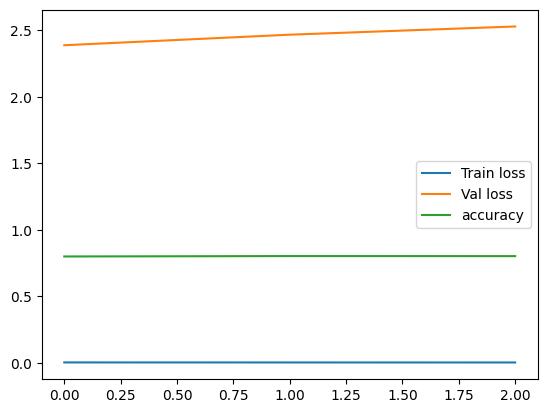

In [11]:

plt.plot(loss_train,"-",label="Train loss")
plt.plot(loss_val,"-",label="Val loss")
plt.plot(acc_val,"-",label="accuracy")
plt.legend()


In [37]:
PATH = f"models/d_{d}_nh_{n_hidden}_lr_{learning_rate:.3f}.pt"
# saving the state
# model.to(device)
# torch.save(model.state_dict(), PATH)
checkpoint = {
"epoch": 2,
"model_state": model.state_dict(),
"optim_state": optimizer.state_dict()
}
# print(optimizer.state_dict())
# FILE = "checkpoint.pth"
torch.save(checkpoint, PATH)

In [59]:
d = 7 # must be an odd number
n_hidden = 512
learning_rate = 1e-2
FILE = f"models/d_{d}_nh_{n_hidden}_lr_{learning_rate:.3f}.pt"
device = "cuda" if torch.cuda.is_available() else "cpu"

model = MLP(d, n_hidden)

optimizer = torch.optim.AdamW(model.parameters(), lr=0)
# optimizer = torch.optim.SGD(model.parameters(), lr=0)
checkpoint = torch.load(FILE)
model.load_state_dict(checkpoint['model_state'])
optimizer.load_state_dict(checkpoint['optim_state'])
epoch = checkpoint['epoch']

# model.load_state_dict(torch.load(PATH))
model.to(device)

MLP(
  (net): Sequential(
    (0): Linear(in_features=48, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=2, bias=True)
    (3): Dropout(p=0.2, inplace=False)
  )
)

In [61]:
# d = 5 # must be an odd number
n_hidden = [512, 512, 512]
learning_rate = [1,1e-2,1e-3]
# device = "cuda" if torch.cuda.is_available() else "cpu"

BATCH_SIZE = 1000
p_err_list = torch.arange(0.01,0.31,0.01)
d_list = [7]
acc = torch.zeros((p_err_list.shape[0],len(d_list)))
for i_d,d in enumerate(d_list):
    # # model = load_model(d,n_hidden[i_d],learning_rate)
    # FILE = f"models/d_{d}_nh_{n_hidden[i_d]}_lr_{learning_rate[i_d]:.3f}.pt"

    # model = MLP(d, n_hidden[i_d])

    # # optimizer = torch.optim.AdamW(model.parameters(), lr=0)
    # optimizer = torch.optim.SGD(model.parameters(), lr=0)
    # checkpoint = torch.load(FILE)
    # model.load_state_dict(checkpoint['model_state'])
    # optimizer.load_state_dict(checkpoint['optim_state'])
    # epoch = checkpoint['epoch']

    # # model.load_state_dict(torch.load(PATH))
    # model.to(device)
    model.eval()
    for i_p, p_err in enumerate(p_err_list):
        dataset = load_dataset("json", data_files={
                'test' : f"datasets/test_d_{d}_p_{p_err:.2f}.json"
            })
        data_loader_test = DataLoader(dataset["test"], batch_size=BATCH_SIZE, collate_fn=collate_fn)

        with torch.no_grad():
            for i_b, batch in enumerate(data_loader_test):
                X = torch.tensor(batch['input']).to(device)
                Y = torch.tensor(batch['target']).to(device)
                err_probs, _ = model(X)
                pred = (err_probs > 0.5).to(Y)
                acc[i_p,i_d] += torch.sum(pred == Y, dim=(0,1)).item()/Y.shape[0]/2
            # print(i_b)
            acc[i_p,i_d] /= (i_b+1)

    model.train()
    # del model


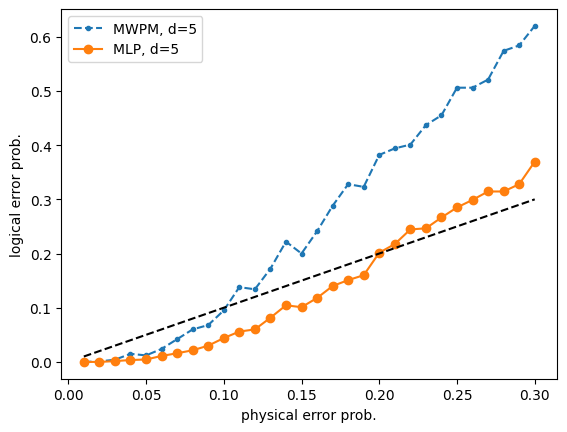

In [53]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for d in d_list:
    p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    plt.plot(p_err_list,logical_err_mwpm,".--",label=f"MWPM, d={d}")

plt.plot(p_err_list,1-acc,"o-",label=f"MLP, d={d}")
plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()


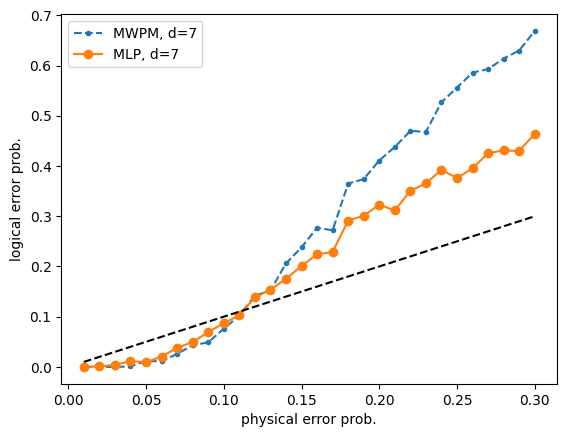

In [62]:
def mwpm_file_reader(d):
    fname = f"results/mwpm_sweep_d_{d}.json"
    f = open(fname)
    data = json.load(f)
    f.close()
    return data['p_err'], data['logical_err']

for d in d_list:
    p_err_list,logical_err_mwpm = mwpm_file_reader(d)
    plt.plot(p_err_list,logical_err_mwpm,".--",label=f"MWPM, d={d}")

plt.plot(p_err_list,1-acc,"o-",label=f"MLP, d={d}")
plt.plot(p_err_list,p_err_list,"k--")
plt.xlabel("physical error prob.")
plt.ylabel("logical error prob.")
plt.legend()
